In [1]:
import argparse
import os
import sys
import torchvision
import torch
from torch.serialization import default_restore_location
from torch.distributions import Poisson
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from PIL import Image
sys.path.append('../')
import data
import models
import utils

In [2]:
diff_checkpoint_path = {
    'White-4-128': '../checkpoints/unet-128-small.pt',
    'White-6-128': '../checkpoints/unet-128-big.pt',
}

In [3]:
dataset = 'ptceo2'
contrast = 'white'
data_path = '/scratch/sm7582/prince/sm7582/datasets/Nanoparticles/ptceo2-1024'
batch_size = 1

USE_CUDA = True
device = torch.device("cuda") if (
        torch.cuda.is_available() and USE_CUDA) else torch.device("cpu")

In [4]:
def load_model(checkpoint_path):
    state_dict = torch.load( checkpoint_path, map_location=lambda s,
                                l: default_restore_location(s,"cpu"))
    
    args = argparse.Namespace(
        **{**vars(state_dict["args"])})
    model = models.build_model(args).to(device)
    model.load_state_dict(state_dict["model"][0])
    model.eval()
    return model

In [5]:
net_dict = {}
for key, checkpoint_path in diff_checkpoint_path.items():
    net_dict[key] = load_model(checkpoint_path).to(device)
    print(f" {key} with parameters {sum(p.numel() for p in net_dict[key].parameters()):,}")

 White-4-128 with parameters 5,613,441
 White-6-128 with parameters 70,504,960


# Check Denoising in Patches

In [6]:
_, val_loader, test_loader = data.build_dataset(dataset, data_path,
                                           test_batch_size=batch_size, rotation_aug = False,
                                           contrast = contrast)

/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


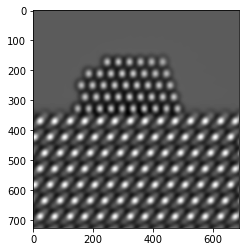

In [7]:
for x in test_loader:
    plt.imshow(x['image'][0,0].numpy(), cmap='gray')
    break

In [8]:
clean = x['image'].to(device)
noisy = Poisson(clean).sample()

In [9]:
for key, net in net_dict.items():
    with torch.no_grad():
        denoised_4 = net(noisy)
        denoised_4_patches = utils.denoise_in_patch(noisy, net)

    valid_psnr = utils.psnr(clean, denoised_4)
    valid_psnr_patches = utils.psnr(clean, denoised_4_patches)

    print(key, valid_psnr, valid_psnr_patches)

White-4-128 38.653305297704364 38.770147535326466
White-6-128 30.387972941392633 34.62837331881014


In [10]:
with torch.no_grad():
    denoised_6 = net_dict['White-6-128'](noisy)
    denoised_6_patches = utils.denoise_in_patch(noisy, net_dict['White-6-128'])

In [11]:
valid_psnr = utils.psnr(clean, denoised_6)
valid_psnr_patches = utils.psnr(clean, denoised_6_patches)
print(valid_psnr, valid_psnr_patches)

30.387972941392633 34.62837331881014


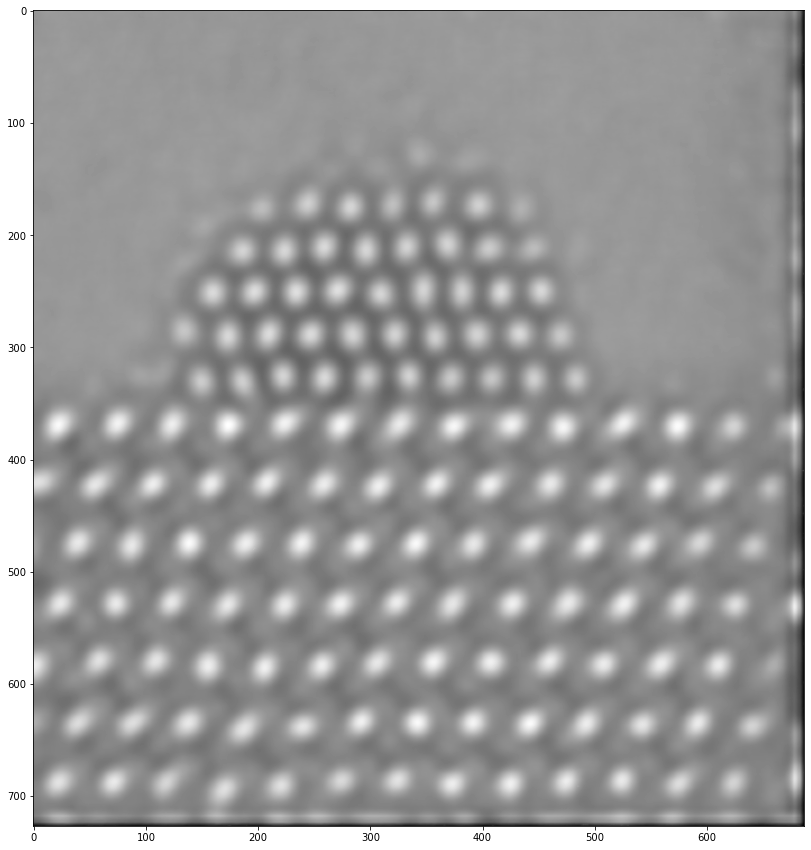

In [12]:
plt.figure(figsize=(15, 15))
plt.imshow(denoised_6[0,0].cpu().numpy(), cmap='gray')

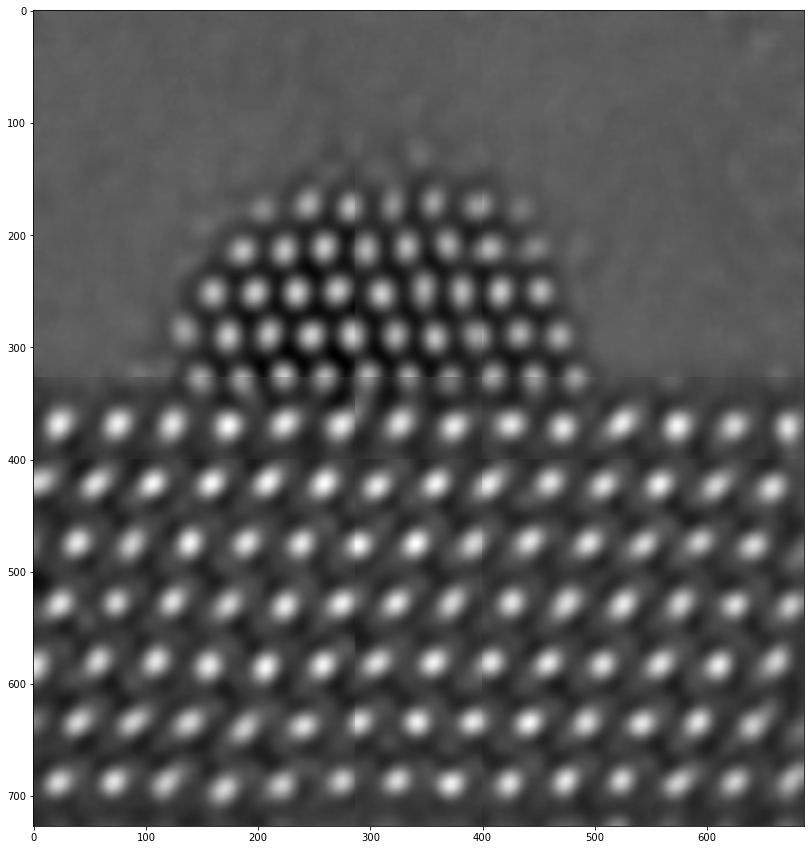

In [13]:
plt.figure(figsize=(15, 15))
plt.imshow(denoised_6_patches[0,0].cpu().numpy(), cmap='gray')

In [14]:
denoised_2_patches = utils.denoise_in_patch(noisy, net_dict['White-6-128'], step = 250, patch_size = 400)

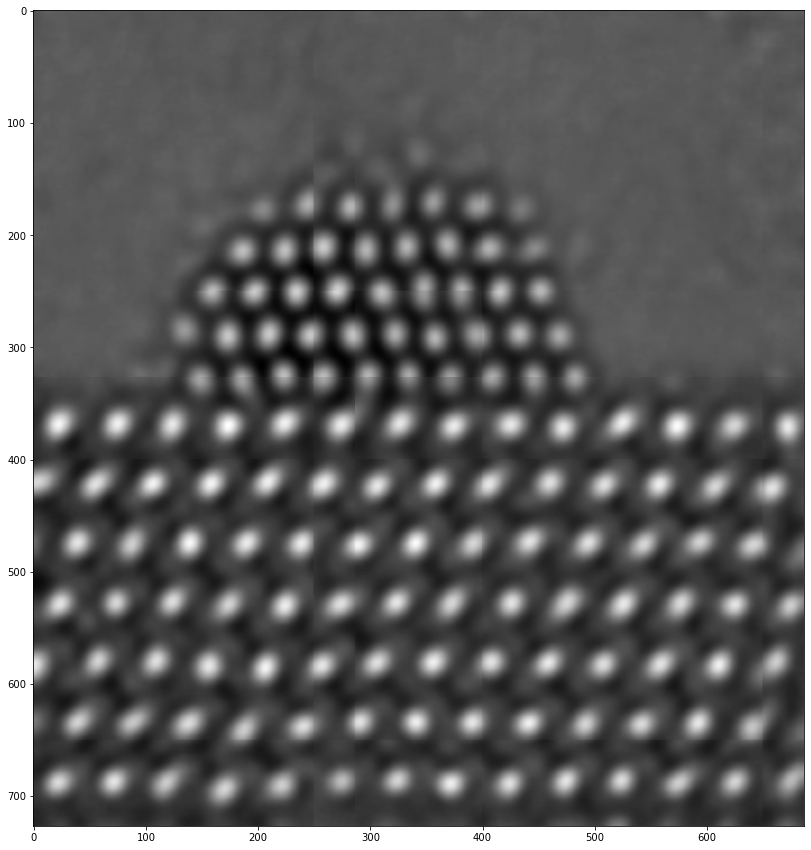

In [15]:
plt.figure(figsize=(15, 15))
plt.imshow(denoised_2_patches[0,0].cpu().numpy(), cmap='gray')

In [16]:
valid_psnr = utils.psnr(clean, denoised_6)
valid_psnr_patches = utils.psnr(clean, denoised_6_patches)

In [17]:
valid_psnr, valid_psnr_patches

(30.387972941392633, 34.62837331881014)

# Mean PSNR on test set

In [18]:
def valid_psnr_ssim(model, valid_loader, noise_scale = 1, denoise_patches = False, 
                    step = 350, patch_size = 400):
    
    valid_meters = {name: utils.AverageMeter() for name in (["valid_psnr", "valid_ssim"])}
    for meter in valid_meters.values():
        meter.reset()

    valid_bar = utils.ProgressBar(valid_loader)
    
    for sample_id, sample in enumerate(valid_bar):
        with torch.no_grad():
            clean = sample["image"].to(device)
            noisy = noisy = Poisson(clean).sample()
            if denoise_patches:
                denoised = utils.denoise_in_patch(noisy, model, step = step, patch_size = patch_size)
            else:
                denoised = model(noisy)
            valid_psnr = utils.psnr(clean / noise_scale, denoised /noise_scale)
            valid_ssim = utils.ssim(clean / noise_scale, denoised /noise_scale)
            valid_meters["valid_psnr"].update(valid_psnr.item())
            valid_meters["valid_ssim"].update(valid_ssim.item())
            
    return valid_meters["valid_psnr"].avg, valid_meters["valid_ssim"].avg   

In [19]:
for key, net in net_dict.items():
    with torch.no_grad():
        denoised_4 = net(noisy)
        denoised_4_patches = utils.denoise_in_patch(noisy, net)

    valid_psnr = utils.psnr(clean, denoised_4)
    valid_psnr_patches = utils.psnr(clean, denoised_4_patches)

    print(key, 'Without patches:', valid_psnr_ssim(net, val_loader), 
           'With patches: ',valid_psnr_ssim(net, val_loader, denoise_patches = True))

  0%|          | 0/279 [00:00<?, ?it/s]/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the ar

White-4-128 Without patches: (38.15751226609743, 0.9886716449259741) With patches:  (38.57619725648249, 0.9891809296530369)


  0%|          | 0/279 [00:00<?, ?it/s]/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the ar

White-6-128 Without patches: (30.462461508364562, 0.9580665281811993) With patches:  (34.58822973316674, 0.9728627443652136)


In [20]:
print('Without patches: ', valid_psnr_ssim(net_dict['White-6-128'], val_loader) )

  0%|          | 0/279 [00:00<?, ?it/s]/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the ar

Without patches:  (30.457156430502568, 0.9581546478518493)


In [21]:
print('With patches: ', valid_psnr_ssim(net_dict['White-6-128'], val_loader, denoise_patches = True) )

  0%|          | 0/279 [00:00<?, ?it/s]/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the ar

With patches:  (34.565650942798314, 0.9727874487346237)


In [22]:
print('With patches: ', valid_psnr_ssim(net_dict['White-6-128'], val_loader, denoise_patches = True, step = 300) )

  0%|          | 0/279 [00:00<?, ?it/s]/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the ar

With patches:  (34.62117920218499, 0.9729424390828407)


In [23]:
print('With patches: ', valid_psnr_ssim(net_dict['White-6-128'], val_loader, denoise_patches = True, step = 400) )

  0%|          | 0/279 [00:00<?, ?it/s]/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the ar

With patches:  (34.61242221331211, 0.9729483254762528)


In [24]:
print('With patches: ', valid_psnr_ssim(net_dict['White-6-128'], val_loader, denoise_patches = True, step = 250) )

  0%|          | 0/279 [00:00<?, ?it/s]/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the ar

With patches:  (34.681952562367435, 0.9732930107021178)


In [25]:
print('With patches: ', valid_psnr_ssim(net_dict['White-6-128'], val_loader, denoise_patches = True, step = 200) )

  0%|          | 0/279 [00:00<?, ?it/s]/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the ar

With patches:  (34.70866462872883, 0.9734055358093345)
